# Tweet Analysis Notebook

In [1]:
%matplotlib inline

from datetime import datetime
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import src.tweet_func as t
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from wordcloud import WordCloud
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(22, 12)})
#plt.style.use('ggplot')

In [2]:
def remove_empties(x):
    """input: a list of words
       output: a list of words with null or empty strings removed"""
    res = []
    for val in x:
        if val != '' and val != ' ':
            res.append(val)
    return res

def remove_stopwords(x, stop_words):
    """input: a list of words
       output: a list of words with stop_words removed"""
    valids = []
    for word in x:
        if word not in stop_words:
            valids.append(word)
    return valids

def clean_tags(x):
    """input: a list of either mentions or hashtags
       output: a list with special characters and numbers removed after the # or @"""
    filtered_list = []
    for word in x:
        cleaned_word = word[0]
        for char in word[1:]:
            if char.isalpha():
                cleaned_word += char
        filtered_list.append(cleaned_word)
    return filtered_list

def remove_phrase(x, leading_char):
    """Removes phrases like mentions or hashtags from a list
    input: x - list
           leading_char - character like @ or #
    output: list without phrases"""
    filtered_list = []
    for word in x:
        if word[0] != leading_char:
            filtered_list.append(word)
    return filtered_list

def process_tweets(df, *args):
    """process tweet data by applying filters specified in args.
    choices are:
        get_mentions     = create column with @twitter_user mentions
        get_hashtags     = create column with #hashtag(s)
        split_tweets     = create column with a list of words from tweet
        lowercase        = force all letters to lowercase in split_tweets list
        remove_nonalpha  = removes special characters and numbers from list
        remove_stopwords = removes common words referencing stop_words list
        
        return: processed dataframe"""
    
    if 'lowercase' in args:
        df['tweets'] = df['tweets'].str.lower()
    if 'get_mentions' in args:
        df['mentions'] = df['tweets'].str.findall(r'@.*?(?=\s|$)')
        df['mentions'] = df['mentions'].apply(lambda x: clean_tags(x))
    if 'get_hashtags' in args:
        df['hashtags'] = df['tweets'].str.findall(r'#.*?(?=\s|$)')
        df['hashtags'] = df['hashtags'].apply(lambda x: clean_tags(x))
    if 'split_tweets' in args:
        df['split_tweets'] = df['tweets'].str.split(' ')
        df['split_tweets'] = df['split_tweets'].apply(lambda x: list(remove_empties(x)))
    if 'remove_mentions' in args:
        df['split_tweets'] = df['split_tweets'].apply(lambda x: list(remove_phrase(x, '@')))
    if 'remove_hashtags' in args:
        df['split_tweets'] = df['split_tweets'].apply(lambda x: list(remove_phrase(x, '#')))
    if 'remove_nonalpha' in args:
        df['split_tweets'] = df['split_tweets'].apply(lambda x: list(map(t.letters, x)))
    if 'remove_stopwords' in args:
        df['split_tweets'] = df['split_tweets'].apply(lambda x: list(remove_stopwords(x, stop_words)))
    # change date/times to datetime
    df['created_at'] = df['created_at'].apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))
    return df

In [8]:
def match_pattern(input_list, pattern):
    """from an input_list, return list values matching the pattern
    input: input_list - list of phrases
           pattern - can use wildcards, such as pattern=*stuff
    return: filtered list with matched values
    ex: match_pattern(['turtle', 'onion', 'pizza', 'cation'], *ion)
        >> ['onion', 'cation']"""
    import fnmatch
    return fnmatch.filter(input_list, pattern)

def get_tags(df, column):
    """gets all unique tags (hashtags or mentions) from a dataframe"""
    tag_list = []
    for tags in df[column]:
        if len(tags) != 0:
            for tag in tags:
                if tag not in tag_list:
                    tag_list.append(tag)
    return tag_list

def count_dictionary(lst):
    count_d = dict()
    for word in lst:
        if word not in count_d.keys():
            count_d[word] = 1
        else:
            count_d[word] += 1
    return count_d

def get_counts(x):
    count = 0
    if len(x) == 0:
        return 0
    for i in x:
        for j in i:
            count += 1
    return count

def get_unique_counts(x):
    unique_vals = []
    if len(x) == 0:
        return 0
    for i in x:
        for j in i:
            if j not in unique_vals:
                unique_vals.append(j)
    return len(unique_vals)

In [4]:
df = pd.read_csv('data/senators.csv', encoding = "ISO-8859-1")
stop_words = set(stopwords.words('english'))
df.rename(columns={"text": "tweets"}, inplace=True)
retweets_df = df.copy()[df['tweets'].str.contains('RT @')]
tweets_df = df[~df["tweets"].str.contains('RT @')]
tweets_df = process_tweets(tweets_df, 
                           'lowercase',
                           'get_mentions',
                           'get_hashtags', 
                           'split_tweets', 
                           'remove_mentions', 
                           'remove_hashtags', 
                           'remove_nonalpha', 
                           'remove_stopwords'
                          )
retweets_df = process_tweets(retweets_df, 
                           'lowercase',
                           'get_mentions',
                           'get_hashtags', 
                           'split_tweets', 
                           'remove_mentions', 
                           'remove_hashtags', 
                           'remove_nonalpha', 
                           'remove_stopwords'
                          )

senator_df = pd.DataFrame({'user': ['amyklobuchar', 'BillCassidy', 'ChrisCoons', 'ChrisVanHollen',
       'ChuckGrassley', 'InhofePress', 'JeffFlake', 'JerryMoran',
       'JohnBoozman', 'JohnCornyn', 'LindseyGrahamSC', 'lisamurkowski',
       'MarkWarner', 'MartinHeinrich', 'maziehirono', 'McCaskillOffice',
       'McConnellPress', 'MikeCrapo', 'PattyMurray', 'RandPaul',
       'RonWyden', 'RoyBlunt', 'Sen_JoeManchin', 'SenAlexander',
       'SenAngusKing', 'SenatorBaldwin', 'SenatorBurr', 'SenatorCantwell',
       'SenatorCardin', 'SenatorCarper', 'SenatorCollins',
       'SenatorDurbin', 'SenatorEnzi', 'SenatorFischer', 'SenatorHassan',
       'SenatorHeitkamp', 'SenatorIsakson', 'SenatorLankford',
       'SenatorLeahy', 'SenatorMenendez', 'SenatorRisch', 'SenatorRounds',
       'SenatorShaheen', 'SenatorStrange', 'SenatorTester',
       'SenatorTimScott', 'SenatorTomUdall', 'SenatorWicker',
       'SenBennetCO', 'SenBillNelson', 'SenBlumenthal', 'SenBobCasey',
       'SenBobCorker', 'SenBooker', 'SenBrianSchatz', 'SenCapito',
       'SenCortezMasto', 'SenCoryGardner', 'SenDanSullivan',
       'sendavidperdue', 'SenDeanHeller', 'SenDonnelly', 'SenDuckworth',
       'SenFeinstein', 'SenFranken', 'SenGaryPeters', 'SenGillibrand',
       'SenJackReed', 'SenJeffMerkley', 'SenJohnBarrasso',
       'SenJohnHoeven', 'SenJohnKennedy', 'SenJohnMcCain', 'SenJohnThune',
       'SenJoniErnst', 'SenKamalaHarris', 'SenMarkey', 'SenMikeLee',
       'SenMurphyOffice', 'senorrinhatch', 'SenPatRoberts',
       'senrobportman', 'SenRonJohnson', 'SenRubioPress', 'SenSanders',
       'SenSasse', 'SenSchumer', 'SenShelby', 'SenSherrodBrown',
       'SenStabenow', 'SenTedCruz', 'SenThadCochran', 'SenThomTillis',
       'SenToddYoung', 'SenTomCotton', 'SenToomey', 'SenWarren',
       'SenWhitehouse', 'SteveDaines', 'timkaine'],
                          'age' : [57, 60, 54, 59, 84, 83, 55, 63, 67, 66, 62, 60, 63, 46, 70, 64, 76, 66, 67, 55, 68, 68, 70, 77, 
                                   74, 56, 62, 59, 74, 71, 65, 73, 74, 67, 62, 62, 73, 50, 78, 64, 74, 63, 71, 65, 61, 52, 69, 66, 
                                   53, 75, 72, 57, 65, 48, 45, 64, 54, 43, 53, 68, 57, 62, 50, 82, 66, 59, 51, 69, 61, 65, 61, 66, 
                                   80, 57, 47, 53, 71, 46, 44, 84, 81, 62, 63, 46, 76, 46, 67, 83, 65, 67, 47, 79, 57, 45, 40, 56, 
                                   68, 62, 55, 60
                                  ]})

tweets_df = pd.merge(tweets_df, senator_df, on='user')
retweets_df = pd.merge(retweets_df, senator_df, on='user')

In [5]:
D_tweets_df = tweets_df[tweets_df['party'] == 'D']
R_tweets_df = tweets_df[tweets_df['party'] == 'R']
I_tweets_df = tweets_df[tweets_df['party'] == 'I']

In [9]:
tweet_hashtags = get_tags(tweets_df, 'hashtags')
tweet_mentions = get_tags(tweets_df, 'mentions')

How many tweets are retweets?

In [7]:
print(f'shape of tweets dataframe: {tweets_df.shape}')
print(f'shape of retweets dataframe: {retweets_df.shape}')
print(f'percent not retweets: {len(tweets_df)/len(df):2.2f}')
print(f'percent retweets: {len(retweets_df)/len(df):2.2f}')

shape of tweets dataframe: (242213, 14)
shape of retweets dataframe: (46402, 14)
percent not retweets: 0.84
percent retweets: 0.16


In [10]:
D_users = D_tweets_df.groupby('user')
D_hashs = D_users.apply(lambda x: get_counts(x['hashtags']))
D_unique_hashs = D_users.apply(lambda x: get_unique_counts(x['hashtags']))
R_users = R_tweets_df.groupby('user')
R_hashs = R_users.apply(lambda x: get_counts(x['hashtags']))
R_unique_hashs = R_users.apply(lambda x: get_unique_counts(x['hashtags']))
I_users = I_tweets_df.groupby('user')
I_hashs = I_users.apply(lambda x: get_counts(x['hashtags']))
I_unique_hashs = I_users.apply(lambda x: get_unique_counts(x['hashtags']))

In [11]:
all_words = [y for x in tweets_df['split_tweets'] for y in x]
word_list = list(filter(lambda x: x != 'amp', all_words))
words = ' '.join(word_list)

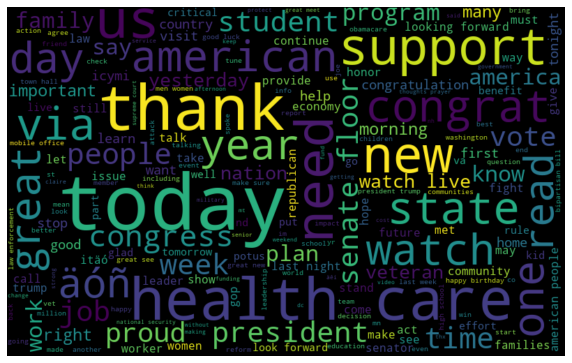

In [12]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [7]:
t.filter_df(retweets_df, 'favorites', 1000000, max)

,created_at,tweets,url,replies,retweets,favorites,user,bioguide_id,party,state,mentions,hashtags,split_tweets
87415,1/20/17 15:49,RT @POTUS: It's been the honor of my life to s...,https://twitter.com/SenatorCantwell/status/822...,19158,632470,1642617,SenatorCantwell,C000127,D,WA,[@POTUS:],[],"[rt, honor, life, serve, made, better, leader,..."
89414,7/20/17 16:48,RT @BarackObama: John McCain is an American he...,https://twitter.com/SenatorCardin/status/88807...,29569,419445,2108865,SenatorCardin,C000141,D,MD,[@BarackObama:],[],"[rt, john, mccain, american, hero, amp, one, b..."
92567,7/20/17 2:43,RT @BarackObama: John McCain is an American he...,https://twitter.com/SenatorCarper/status/88786...,29569,419445,2108865,SenatorCarper,C000174,D,DE,[@BarackObama:],[],"[rt, john, mccain, american, hero, amp, one, b..."
120520,10/3/17 14:19,RT @MichelleObama: Happy 25th anniversary @bar...,https://twitter.com/SenatorLeahy/status/915219...,25827,287230,1315041,SenatorLeahy,L000174,D,VT,"[@MichelleObama:, @barackobama.]",[],"[rt, happy, th, anniversary, quarter, century,..."
129663,10/10/17 20:59,"RT @Malala: 5 years ago, I was shot in an atte...",https://twitter.com/SenatorShaheen/status/9178...,11053,356284,1156950,SenatorShaheen,S001181,D,NH,[@Malala:],[],"[rt, , years, ago, shot, attempt, stop, speaki..."
160184,1/20/17 22:13,RT @POTUS44: It's been the honor of my life to...,https://twitter.com/SenBooker/status/822567739...,19158,632470,1642608,SenBooker,B001288,D,NJ,[@POTUS44:],[],"[rt, honor, life, serve, made, better, leader,..."
196359,1/20/17 1:25,RT @FLOTUS: Being your First Lady has been the...,https://twitter.com/SenGillibrand/status/82225...,19142,368413,1167951,SenGillibrand,G000555,D,NY,[@FLOTUS:],[],"[rt, first, lady, honor, lifetime, bottom, hea..."


In [8]:
t.filter_df(tweets_df, 'favorites', 500000, max)

,created_at,tweets,url,replies,retweets,favorites,user,bioguide_id,party,state,mentions,hashtags,split_tweets
244285,8/15/17 22:06,".@realDonaldTrump, you are embarrassing our co...",https://twitter.com/SenSanders/status/89758034...,7510,201134,565707,SenSanders,S000033,I,VT,"[@realDonaldTrump,]",[],"[realdonaldtrump, embarrassing, country, milli..."
245162,2/25/17 13:56,.@realDonaldTrump They did. It wasn't. https:/...,https://twitter.com/SenSanders/status/83548856...,11072,207143,520384,SenSanders,S000033,I,VT,[@realDonaldTrump],[],"[realdonaldtrump, wasnt, httpstcoxqtrjper]"
245420,1/21/17 22:15,"President Trump, you made a big mistake. By tr...",https://twitter.com/SenSanders/status/82293062...,13929,454660,975012,SenSanders,S000033,I,VT,[],[],"[president, trump, made, big, mistake, trying,..."


In [9]:
t.filter_df(tweets_df, 'retweets', 0, max)

,created_at,tweets,url,replies,retweets,favorites,user,bioguide_id,party,state,mentions,hashtags,split_tweets
245420,1/21/17 22:15,"President Trump, you made a big mistake. By tr...",https://twitter.com/SenSanders/status/82293062...,13929,454660,975012,SenSanders,S000033,I,VT,[],[],"[president, trump, made, big, mistake, trying,..."


In [10]:
t.filter_df(retweets_df, 'retweets', 0, max)

,created_at,tweets,url,replies,retweets,favorites,user,bioguide_id,party,state,mentions,hashtags,split_tweets
167894,4/11/17 17:47,RT @carterjwm: HELP ME PLEASE. A MAN NEEDS HIS...,https://twitter.com/SenCortezMasto/status/8518...,38225,3644423,1016576,SenCortezMasto,C001113,D,NV,[@carterjwm:],[],"[rt, help, please, man, needs, nuggs, httpstco..."


In [11]:
t.filter_df(retweets_df, 'replies', 0, max)

,created_at,tweets,url,replies,retweets,favorites,user,bioguide_id,party,state,mentions,hashtags,split_tweets
155684,8/12/17 20:09,RT @realDonaldTrump: We ALL must be united &am...,https://twitter.com/SenBobCorker/status/896463...,66872,59242,194351,SenBobCorker,C001071,R,TN,[@realDonaldTrump:],[],"[rt, must, united, amp, condemn, hate, stands,..."
173545,8/13/17 0:06,RT @realDonaldTrump: We ALL must be united &am...,https://twitter.com/sendavidperdue/status/8965...,66872,59242,194346,sendavidperdue,P000612,R,GA,[@realDonaldTrump:],[],"[rt, must, united, amp, condemn, hate, stands,..."


In [12]:
t.filter_df(tweets_df, 'replies', 0, max)

,created_at,tweets,url,replies,retweets,favorites,user,bioguide_id,party,state,mentions,hashtags,split_tweets
211234,9/22/17 18:06,I cannot in good conscience vote for Graham-Ca...,https://twitter.com/SenJohnMcCain/status/91129...,38416,56606,190133,SenJohnMcCain,M000303,R,AZ,[],[],"[cannot, good, conscience, vote, grahamcassidy..."
